## Preparation

asd

In [2]:
import math
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from e1_co2_fixing.chemistry import MOLECULES, CHEMISTRY

theme_set(theme_minimal())

In [2]:
def proteome_stats(proteome: list[list], records: list[dict], size: int, record: dict):
    records.append({
        **record,
        "n": len(proteome),
        "v": "proteins/genome"
    })
    if len(proteome) > 0:
        n_doms = sum(len(d) for d in proteome)
        records.append({
            **record,
            "n": n_doms / len(proteome),
            "v": "domains/protein"
        })
        records.append({
            **record,
            "n": n_doms * genetics.dom_size / size,
            "v": "coding nts/nt"
        })

genetics = ms.Genetics()

records = []
for size in (500, 2000):
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"size": size})

df = pd.DataFrame.from_records(records)

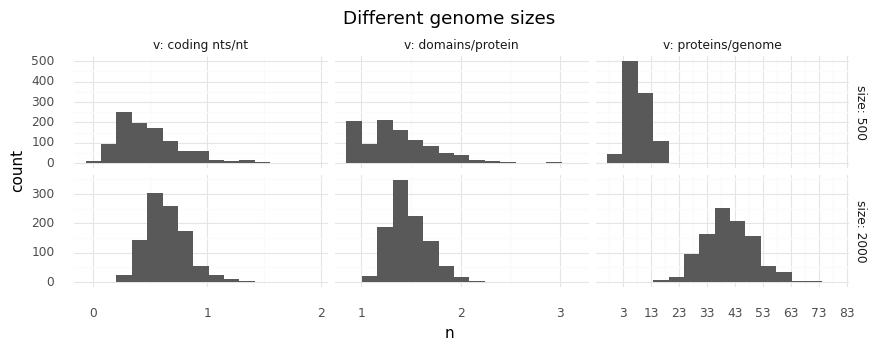

<ggplot: (8787764786125)>

In [3]:
def get_breaks(l: list[float]) -> list[float]:
    lower = math.floor(min(l))
    upper = math.ceil(max(l))
    return range(lower, upper, math.ceil((upper - lower) / 10))

(ggplot(df)
    + geom_histogram(aes(x="n"), bins=15)
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + scale_x_continuous(breaks=get_breaks)
    + theme(figure_size=(10, 3))
    + ggtitle("Different genome sizes"))

In [5]:
MOL_2_I = {d.name: i for i, d in enumerate(MOLECULES)}
CO2_I = MOL_2_I["CO2"]

def get_co2_positions(world: ms.World) -> tuple[list[int], list[int]]:
    s = world.map_size
    ticks = list(range(0, s, 32))[1:]
    n = len(ticks)
    xs = ticks * n
    ys = [d for d in ticks for _ in range(n)]
    return xs, ys

def init_co2(world: ms.World, xs: list[int], ys: list[int]):
    inner = slice(min(xs), max(xs))
    outer = slice(min(xs) - 15, max(xs) + 15)
    world.molecule_map[CO2_I] = 20.0
    world.molecule_map[CO2_I, outer, outer] = 40.0
    world.molecule_map[CO2_I, inner, inner] = 60.0

def add_co2(world: ms.World, xs: list[int], ys: list[int]):
    world.molecule_map[CO2_I, xs, ys] = 100.0
    world.molecule_map[CO2_I, [0, -1]] = 1.0
    world.molecule_map[CO2_I, :, [0, -1]] = 1.0

world = ms.World(chemistry=CHEMISTRY, mol_map_init="zeros")
co2_xs, co2_ys = get_co2_positions(world=world)
init_co2(world=world, xs=co2_xs, ys=co2_ys)
ticks = list(range(world.map_size))
xs = ticks * world.map_size
ys = [d for d in ticks for _ in range(world.map_size)]

map_records = []
line_records = []
vlines = []
for si in range(2_001):
    add_co2(world=world, xs=co2_xs, ys=co2_ys)
    mu = world.molecule_map[CO2_I].mean().item()
    line_records.append({"step": si, "[CO2]": mu})
    if si % 500 == 0:
        vlines.append(si)
        flat_mols = world.molecule_map.flatten().tolist()
        for x, y, c in zip(xs, ys, flat_mols):
            map_records.append({"step": si, "x": x, "y": y, "[CO2]": c})
    world.diffuse_molecules()

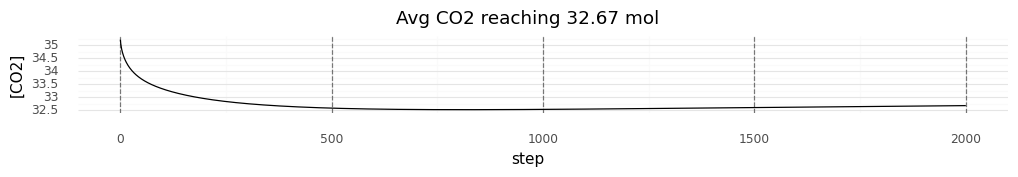

<ggplot: (8750479011365)>

In [7]:
df = pd.DataFrame.from_records(line_records)
mu = world.molecule_map[CO2_I].mean().item()
g = (ggplot(df)
    + geom_line(aes(x="step", y="[CO2]"))
    + theme(figure_size=(12, 1))
    + ggtitle(f"Avg CO2 reaching {mu:.2f} mol"))
for xint in vlines:
    g += geom_vline(xintercept=xint, alpha=.5, linetype="dashed")
g

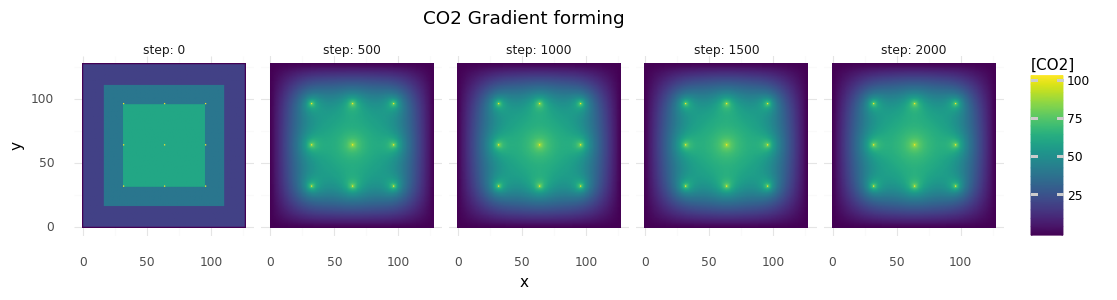

<ggplot: (8750479901959)>

In [8]:
df = pd.DataFrame.from_records(map_records)
(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="[CO2]"))
    + facet_grid(". ~ step", labeller="label_both")
    + coord_equal(expand=True)
    + theme(figure_size=(12, 4))
    + ggtitle("CO2 Gradient forming"))

In [7]:
world = ms.World(chemistry=CHEMISTRY)
genomes = [ms.random_genome(s=1000) for _ in range(100)]
world.add_random_cells(genomes=genomes)
lKe = world.kinetics.E / world.abs_temp / GAS_CONSTANT / 2.303

records = []
for lke in lKe[lKe != 0.0].flatten().tolist():
    records.append({"lKe": lke})

df = pd.DataFrame.from_records(records)

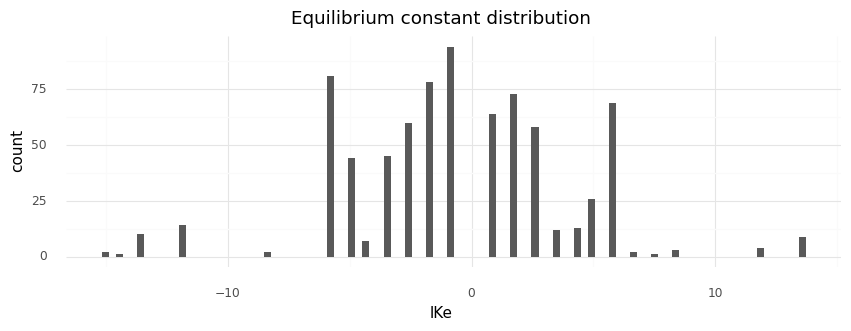

<ggplot: (8787764644331)>

In [8]:
(ggplot(df)
    + geom_histogram(aes(x="lKe"), bins=100)
    + theme(figure_size=(10, 3))
    + ggtitle("Equilibrium constant distribution"))

In [9]:
def increasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return t ** n / (t ** n + k ** n)

def decreasing(t: torch.Tensor, k: float, n: int) -> torch.Tensor:
    return k ** n / (t ** n + k ** n)

In [10]:
def kill_energy(d: float):
    return decreasing(d, 0.5, 3)

n_steps = 1000
categories = [1.0, 2.0, 3.0, 4.0, 5.0]

x = torch.arange(0, 10, .01)
df1 = pd.DataFrame({
    "x": x.tolist(),
    "p": kill_energy(x).tolist(),
    "action": "p(kill) x [M]"
})

records = []
for x in categories:
    for step in range(n_steps):
        records.append({
            "x": step,
            "[M]": x,
            "p": (1 - (1 - kill_energy(x)) ** step),
            "action": "p(killed) x steps",
        })

df2 = pd.DataFrame.from_records(records)

/home/marc/anaconda3/envs/luca/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


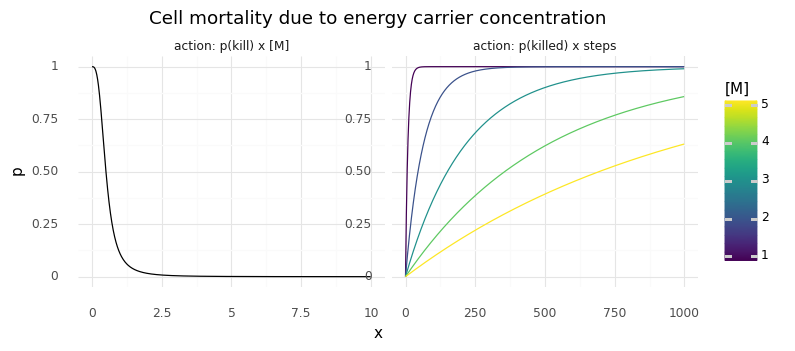

<ggplot: (8787763612124)>

In [11]:
(ggplot(mapping=aes(y="p", x="x"))
    + geom_line(data=df1)
    + geom_line(aes(color="[M]", group="[M]"), data=df2)
    + facet_wrap("~ action", labeller="label_both", scales="free")
    + theme(figure_size=(8, 3))
    + ggtitle("Cell mortality due to energy carrier concentration"))

In [12]:
def divide_carbon(d: float):
    return increasing(d, 15.0, 3)

n_steps = 1000
categories = [1.0, 2.0, 3.0, 4.0, 5.0]

x = torch.arange(0, 10, .01)
df1 = pd.DataFrame({
    "x": x.tolist(),
    "p": divide_carbon(x).tolist(),
    "action": "p(replicate) x [M]"
})

records = []
for x in categories:
    for step in range(n_steps):
        records.append({
            "x": step,
            "[M]": x,
            "p": (1 - (1 - divide_carbon(x)) ** step),
            "action": "p(replicated) x steps",
        })

df2 = pd.DataFrame.from_records(records)

/home/marc/anaconda3/envs/luca/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


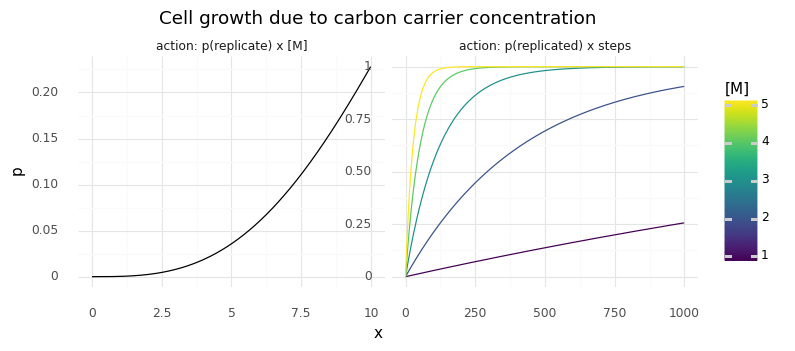

<ggplot: (8787763531228)>

In [13]:
(ggplot(mapping=aes(y="p", x="x"))
    + geom_line(data=df1)
    + geom_line(aes(color="[M]", group="[M]"), data=df2)
    + facet_wrap("~ action", labeller="label_both", scales="free")
    + theme(figure_size=(8, 3))
    + ggtitle("Cell growth due to carbon carrier concentration"))

In [14]:
def kill_genome(d: float):
    return increasing(d, 4000.0, 7)

n_steps = 1000
categories = [500, 1000, 1500, 2000, 2500]

x = torch.arange(0.0, 4000.0, 100.0)
df1 = pd.DataFrame({
    "x": x.tolist(),
    "p": kill_genome(x).tolist(),
    "action": "p(kill) x size"
})

records = []
for x in categories:
    for step in range(n_steps):
        records.append({
            "x": step,
            "size": x,
            "p": (1 - (1 - kill_genome(x)) ** step),
            "action": "p(killed) x steps",
        })

df2 = pd.DataFrame.from_records(records)

/home/marc/anaconda3/envs/luca/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


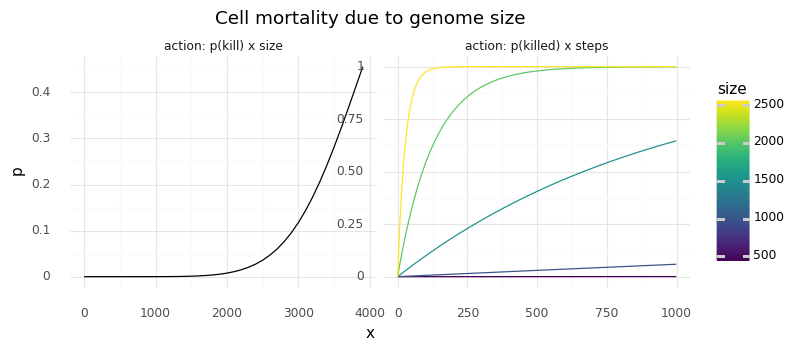

<ggplot: (8787763935374)>

In [15]:
(ggplot(mapping=aes(y="p", x="x"))
    + geom_line(data=df1)
    + geom_line(aes(color="size", group="size"), data=df2)
    + facet_wrap("~ action", labeller="label_both", scales="free")
    + theme(figure_size=(8, 3))
    + ggtitle("Cell mortality due to genome size"))

In [16]:
def sample(p: torch.Tensor) -> list[int]:
    idxs = torch.argwhere(torch.bernoulli(p))
    return idxs.flatten().tolist()

n_cells = 1000
n_steps = 100
conditions = [
    (3.0, 1.0, 1000.0),  # average
    (3.0, 3.0, 1000.0),  # high carbon
    (3.0, 0.1, 1000.0),  # low carbon
    (5.0, 3.0, 1000.0),  # high energy high carbon
    (3.0, 3.0, 2000.0),  # high carbon but large genome
]

records = []
for e, c, s in conditions:
    label = f"e{e:.0f},c{c:.0f},s{s:.0f}"
    E = torch.ones(n_cells) * e
    C = torch.ones(n_cells) * c
    S = torch.ones(n_cells) * s
    for step in range(n_steps):
        ies = sample(kill_energy(E))
        iss = sample(kill_genome(S))
        keep = torch.ones(E.size(), dtype=bool)
        keep[list(set(ies + iss))] = False
        E = E[keep]
        C = C[keep]
        S = S[keep]

        ics = sample(divide_carbon(C))
        E = torch.cat([E, torch.ones(len(ics)) * e])
        C = torch.cat([C, torch.ones(len(ics)) * c])
        S = torch.cat([S, torch.ones(len(ics)) * s])
        
        records.append({
            "step": step,
            "label": label,
            "cells": E.size(0),
        })

        if E.size(0) > 1e6:
            break

df = pd.DataFrame.from_records(records)

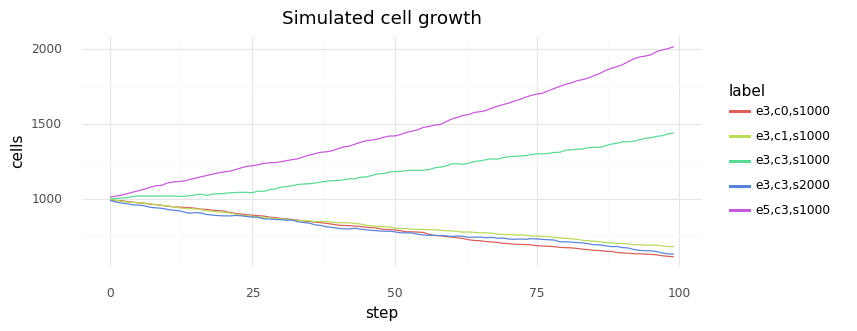

<ggplot: (8787763770850)>

In [17]:
(ggplot(df, aes(y="cells", x="step"))
    + geom_line(aes(color="label"))
    + theme(figure_size=(8, 3))
    + ggtitle("Simulated cell growth"))